In [57]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import ipywidgets as widgets
from ipywidgets import interact
from scipy.ndimage import rotate
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import cv2

# Introduction

In [58]:
# Directory di Chiara
TRAIN_DATASET_PATH = "/Users/chiaracangelosi/Documents/1-Uni/DataScience/Dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

#Directory di Gianluca
#TRAIN_DATASET_PATH= "C:/Users/g2not/Desktop/Università/Data Mining and Machine Learning/Progetto/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Percorso completo del file FLAIR
file_path = os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_355", "BraTS20_Training_355_flair.nii")

# Carica il file .nii come array NumPy
test_image_flair = nib.load(file_path).get_fdata()

# Stampa informazioni sull'immagine
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Shape:  (240, 240, 155)
Dtype:  float64
Min:  0.0
Max:  1854.603271484375


# Data Visualization

N.B. nel progetto github viene effettuato il rescaling slice-wise

In [59]:
# Rescaling voxel-wise a [0, 1]
test_image_flair = (test_image_flair - np.min(test_image_flair)) / (np.max(test_image_flair) - np.min(test_image_flair))

# Verifica
print("Rescaled min:", test_image_flair.min())
print("Rescaled max:", test_image_flair.max())

Rescaled min: 0.0
Rescaled max: 1.0


In [60]:
# Carica il file .nii come array NumPy
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
# Rescaling voxel-wise a [0, 1]
test_image_t1 = (test_image_t1 - np.min(test_image_t1)) / (np.max(test_image_t1) - np.min(test_image_t1))

# Carica il file .nii come array NumPy
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
# Rescaling voxel-wise a [0, 1]
test_image_t1ce = (test_image_t1ce - np.min(test_image_t1ce)) / (np.max(test_image_t1ce) - np.min(test_image_t1ce))

# Carica il file .nii come array NumPy
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
# Rescaling voxel-wise a [0, 1]
test_image_t2 = (test_image_t2 - np.min(test_image_t2)) / (np.max(test_image_t2) - np.min(test_image_t2))

test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()


In [61]:
# === Colori per la maschera ===
labels = [0, 1, 2, 4]
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background (0)', 'NCR & NET (1)', 'Edema (2)', 'Enhancing Tumor (4)']
cmap_mask = ListedColormap(colors)
norm = BoundaryNorm([0, 0.5, 1.5, 3, 5], cmap_mask.N)

# === Visualizzazione dinamica ===
def show_slice(slice_idx):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    # MRI modalities
    titles = ['T1', 'T1ce', 'T2', 'FLAIR']
    volumes = [test_image_t1, test_image_t1ce, test_image_t2, test_image_flair]

    for i in range(4):
        axs[i // 3, i % 3].imshow(volumes[i][:, :, slice_idx], cmap='gray')
        axs[i // 3, i % 3].set_title(titles[i])
        axs[i // 3, i % 3].axis('off')

    # Mask
    axs[1, 1].imshow(test_image_seg[:, :, slice_idx], cmap=cmap_mask, norm=norm)
    axs[1, 1].set_title('Mask')
    axs[1, 1].axis('off')

    # Legend
    axs[1, 2].axis('off')
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(labels))]
    axs[1, 2].legend(handles=patches, loc='center')

    plt.tight_layout()
    plt.show()

# === Interfaccia interattiva ===
interact(
    show_slice,
    slice_idx=widgets.IntSlider(
        value=95,
        min=0,
        max=test_image_t1.shape[2] - 1,
        step=1,
        description='Slice:',
        continuous_update=True
    )
)

interactive(children=(IntSlider(value=95, description='Slice:', max=154), Output()), _dom_classes=('widget-int…

<function __main__.show_slice(slice_idx)>

In [62]:
# === Funzione per visualizzare le tre viste ===
def show_views(slice_idx):
    fig = plt.figure(figsize=(12, 5))
    
    # Transverse View (axial): [x, y, slice]
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(test_image_t1ce[:, :, slice_idx], cmap='gray')
    ax1.set_title(f'T1 - Transverse View (Z={slice_idx})')
    ax1.axis('off')
    
    # Frontal View (coronal): [x, slice, z] → rotate for readability
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(rotate(test_image_t1ce[:, slice_idx, :], 90, reshape=True), cmap='gray')
    ax2.set_title(f'T1 - Frontal View (Y={slice_idx})')
    ax2.axis('off')
    
    # Sagittal View: [slice, y, z] → rotate for readability
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(rotate(test_image_t1ce[slice_idx, :, :], 90, reshape=True), cmap='gray')
    ax3.set_title(f'T1 - Sagittal View (X={slice_idx})')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

# === Slider interattivo ===
# Usa la dimensione più piccola per non eccedere l'indice valido in nessuna direzione
max_index = min(test_image_t1ce.shape)

interact(
    show_views,
    slice_idx=widgets.IntSlider(
        value=95,
        min=0,
        max=max_index - 1,
        step=1,
        description='Slice:',
        continuous_update=True
    )
)

interactive(children=(IntSlider(value=95, description='Slice:', max=154), Output()), _dom_classes=('widget-int…

<function __main__.show_views(slice_idx)>

In [63]:
# === Mappa colori e normalizzazione (adatta a BraTS ad esempio)
labels = [0, 1, 2, 4]
colors = ['black', 'green', 'yellow', 'lightblue']
class_names = ['Background (0)', 'NCR/NET (1)', 'Edema (2)', 'Enhancing Tumor (4)']
cmap = ListedColormap(colors)
norm = BoundaryNorm([0, 0.5, 1.5, 3, 5], len(colors))

# === Funzione dinamica
def show_segmented_slice(slice_idx):
    # Isola ogni classe come maschera separata (usando NaN per trasparenza)
    seg_0 = test_image_seg.copy()
    seg_0[seg_0 != 0] = np.nan
    
    seg_1 = test_image_seg.copy()
    seg_1[seg_1 != 1] = np.nan
    
    seg_2 = test_image_seg.copy()
    seg_2[seg_2 != 2] = np.nan
    
    seg_4 = test_image_seg.copy()
    seg_4[seg_4 != 4] = np.nan

    # Legenda personalizzata
    legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

    # Plot
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))

    ax[0].imshow(test_image_seg[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[0].set_title('Original Segmentation')
    ax[0].legend(handles=legend, loc='lower left')
    ax[0].axis('off')

    ax[1].imshow(seg_0[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[1].set_title('Class 0 (Background)')
    ax[1].axis('off')

    ax[2].imshow(seg_1[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[2].set_title('Class 1 (NCR/NET)')
    ax[2].axis('off')

    ax[3].imshow(seg_2[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[3].set_title('Class 2 (Edema)')
    ax[3].axis('off')

    ax[4].imshow(seg_4[:, :, slice_idx], cmap=cmap, norm=norm)
    ax[4].set_title('Class 4 (Enhancing Tumor)')
    ax[4].axis('off')

    plt.tight_layout()
    plt.show()

# === Slider interattivo
interact(
    show_segmented_slice,
    slice_idx=widgets.IntSlider(
        value=95,
        min=0,
        max=test_image_seg.shape[2] - 1,
        step=1,
        description='Slice:',
        continuous_update=True
    )
)

interactive(children=(IntSlider(value=95, description='Slice:', max=154), Output()), _dom_classes=('widget-int…

<function __main__.show_segmented_slice(slice_idx)>

# Data Splitting

In [64]:
# Ottieni la lista degli ID (ultime parti dei path delle directory)
train_and_test_ids = [f.name for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# Split in: 80% train+test, 20% validation
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2, random_state=42)

# Split train+test in: 85% train, 15% test (≈12% del totale va a test)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 250
Validation length: 74
Test length: 45


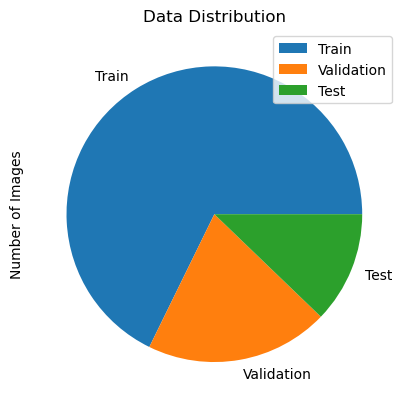

In [65]:
plt.pie(
        [len(train_ids), len(val_ids), len(test_ids)],
        labels=['Train', 'Validation', 'Test'],
       )

plt.legend(loc='upper right')

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

# Data Generator

In [66]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING'
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 
IMG_SIZE=128

In [67]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            t1ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


print("Numero di batch nel training set:", len(training_generator))
print("Numero di batch nel validation set:", len(valid_generator))
print("Numero di batch nel test set:", len(test_generator))

Numero di batch nel training set: 250
Numero di batch nel validation set: 74
Numero di batch nel test set: 45


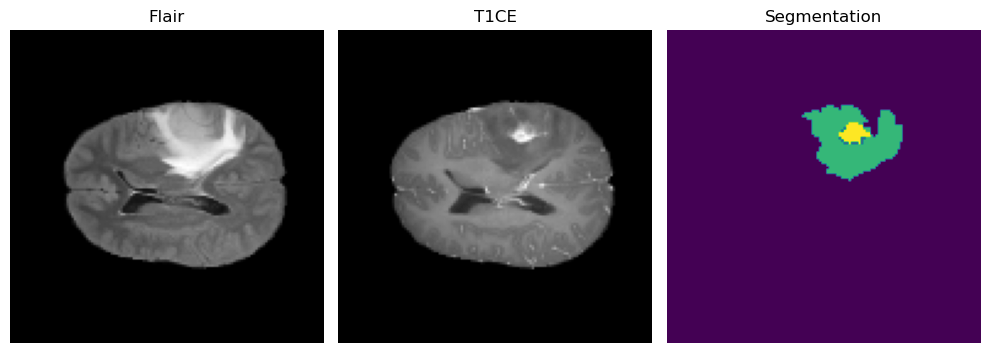

In [68]:
# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve the ninth batch from the training generator
X_batch, Y_batch = training_generator[8]

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 60  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

# Metrics

In [69]:
#The pixel_accuracy function calculates the percentage of correctly classified pixels, 
#that is how many pixels the model predicted with the correct class out of the total number of pixels.
def pixel_accuracy(y_true, y_pred):
    y_true_labels = K.argmax(y_true, axis=-1)
    y_pred_labels = K.argmax(y_pred, axis=-1)
    matches = K.cast(K.equal(y_true_labels, y_pred_labels), dtype='float32')
    return K.mean(matches)

In [70]:
#The mean_iou function calculates the Intersection over Union (IoU) for each of the 4 classes (no tumor, necrotic, edema, enhancing), 
#and then returns the average IoU across all classes.
def mean_iou(y_true, y_pred, epsilon=1e-6):
    iou_scores = []
    for i in range(4):
        y_true_c = K.flatten(y_true[:, :, :, i])
        y_pred_c = K.flatten(y_pred[:, :, :, i])
        intersection = K.sum(y_true_c * y_pred_c)
        union = K.sum(y_true_c) + K.sum(y_pred_c) - intersection
        iou = (intersection + epsilon) / (union + epsilon)
        iou_scores.append(iou)
    return K.mean(tf.stack(iou_scores))

In [71]:
# The function dice_coef calculates the average Dice coefficient across all 4 segmentation classes.
def dice_coef(y_true, y_pred, smooth=1.0):
    total_dice = 0
    for i in range(4):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.flatten(y_pred[:, :, :, i])
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        total_dice += dice
    return total_dice / 4

In [72]:
# Define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon) 


In [73]:
def sensitivity(y_true, y_pred, epsilon=1e-6):
    sensitivities = []
    for i in range(1, 4):  # class 0 is ignored
        y_true_c = K.flatten(y_true[:, :, :, i])
        y_pred_c = K.flatten(y_pred[:, :, :, i])
        tp = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
        fn = K.sum(K.round(K.clip(y_true_c * (1 - y_pred_c), 0, 1)))
        recall = tp / (tp + fn + epsilon)
        sensitivities.append(recall)
    return K.mean(tf.stack(sensitivities))


In [74]:
def precision(y_true, y_pred, epsilon=1e-6):
    precisions = []
    for i in range(1, 4):  # class 0 is ignored
        y_true_c = K.flatten(y_true[:, :, :, i])
        y_pred_c = K.flatten(y_pred[:, :, :, i])
        tp = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
        fp = K.sum(K.round(K.clip((1 - y_true_c) * y_pred_c, 0, 1)))
        prec = tp / (tp + fp + epsilon)
        precisions.append(prec)
    return K.mean(tf.stack(precisions))

In [75]:
def specificity(y_true, y_pred, epsilon=1e-6):
    specificities = []
    for i in range(1, 4):  # class 0 is ignored
        y_true_c = K.flatten(y_true[:, :, :, i])
        y_pred_c = K.flatten(y_pred[:, :, :, i])
        tn = K.sum(K.round(K.clip((1 - y_true_c) * (1 - y_pred_c), 0, 1)))
        fp = K.sum(K.round(K.clip((1 - y_true_c) * y_pred_c, 0, 1)))
        spec = tn / (tn + fp + epsilon)
        specificities.append(spec)
    return K.mean(tf.stack(specificities))
